# Random-graph UD-MIS (Classical)

$$
H = -\sum_{i \in V} n_i + u \sum_{i,j \in E} n_i n_j
$$

Our goal is to find one of the ground state(s) - a solution to the UD-MIS problem - automatically through Monte Carlo sampling.

The probability distribution of the Ising model at temperature $T$ is given by the Gibbs distribution:

$$p(\sigma; T) = \frac{1}{Z(T)}\exp\left(-\frac{H(\sigma)}{T}\right)$$,

where $Z(T)$ is the normalization constant (also known as the *partition function*).

We solved the unit-disk maximum independent set (UD-MIS) problem using classical simulated annealing, for the proposed Toy Graph.
![Task 1: Result](./img/Task1_ToyGraph.png)
On the above plot each circle is centered on the coordinates of the vertice, with a unit diameter. The vertices which are connected by an edge are the ones for which the two circles intersect, meaning that the distance between the centers is less than the unit. Circles in grey in the background are non occupied vertices, while blue circles on the foreground are occupied vertices. The result is compliant with the constraint of non overlap and solving the problem with brute force confirms that it is indeed an optimal solution. 

For the above Toy Graph the brute force solver goes faster than the classical annealing. To start demonstrating an advantage of simmulated annealing, we solved the problem for a random problem. The random graphs are parametrised by two values : the number of vertices $N$ and the density $d$. The vertices coordinates are uniformly sampled in a square of side length $c$. The size of the square is chosen such as its surface equals the number of vertices divided by the density $d = N /c^2$. Therefore the two coordinates are sampled over $0$ to $c = \sqrt{N/d}$

The two implementations start to be equivalent in term of runtime around $N=20$ for density $d=1$. Several solutions are optimal
![Task 1: Result](./img/Task1_RandomGraph20.png)

# Initalisation

In [135]:
import numpy as np
import matplotlib.pyplot as plt

from abstract_udmis import AbstractUDMIS

%matplotlib inline

In [136]:
import random as rand

In [137]:
import time

# UDMIS Class

Below you'll find code for the UDMIS model of interest. Strictly speaking, for the purposes of performing the Monte Carlo simulation we can simply compute the required energy differences using two calls to the energy function. However, we can often save significant computation time by writing a specialised function for the energy difference that avoids unnecessary calculations. Simply put, calculating the energy of a configuration of occupations requires you to iterate over all vertices in the graph, but the energy change associated with a single-occupation-flip can be computed just from values of the connected vertices.

Two functions to plot the occupation and solve the problem with brute force were added.

In [138]:
class UDMIS(AbstractUDMIS):
    def __init__(self, u, graph):
        super().__init__()
        self.u, self.graph = u, graph
        self.num_vertices = len(self.graph)
        print(self.num_vertices)
        # initialize system at infinite temperature
        # i.e. vertices are completely random and uncorrelated
        self.occupations = np.random.rand(self.num_vertices) < 0.5
        self.edges = self.find_edges()
    
    def find_edges(self):
        #num_pairs = int(self.num_vertices*(self.num_vertices)*0.5)
        edges = np.zeros((self.num_vertices, self.num_vertices), dtype=bool)
        
        for i in range(self.num_vertices-1):
            x_i, y_i = graph[i] # these are the x, y coordinates of the i'th vertex in the graph
            for j in range(i+1, self.num_vertices):
                x_j, y_j = graph[j] # these are the x, y coordinates of the j'th vertex in the graph
                
                # calculate the distance between vertices
                dij = np.sqrt((x_i - x_j)**2. + (y_i - y_j)**2.)
                if dij <= 1.0:
                    edges[i,j] = True
                    edges[j,i] = True
                    
        return edges
        
    def energy(self):
        """Returns the energy of the current spin configuration"""
        # interaction term
        interaction_term = 0
        vertex_term = 0
        for i in range(self.num_vertices-1):
            for j in range(i+1, self.num_vertices):
                
                # check if there is an edge
                if self.edges[i,j]:
                    interaction_term += self.occupations[i]*self.occupations[j]
                
            vertex_term += self.occupations[i]
        
        # missed the last vertex
        vertex_term += self.occupations[self.num_vertices-1]
    
        return u*interaction_term - vertex_term

    def energy_diff(self, i):
        connections = np.where(self.edges[i,:])[0]
        num_adjacent_occupied = sum(self.occupations[connections])
        
        if self.occupations[i] == 1:
            # flipping an occupied vertex increases the vertex term, decreases the interaction term
            vertex_term_change = 1.
            interaction_term_change = -u*num_adjacent_occupied
        
        elif self.occupations[i] == 0:
            # flipping an unoccupied vertex decreases the vertex term, increases the interaction term
            vertex_term_change = -1.
            interaction_term_change = u*num_adjacent_occupied 

        return interaction_term_change + vertex_term_change
    
    def rand_vertex(self):
        """Selects a site in the graph at random"""
        return np.random.randint(self.num_vertices)        
    
    def draw_graph(self,occupations = None):
        
        # inner function
        def draw_circles(ax,xs,ys,cs):

            # plot the non activated vertices in the background
            for x,y,c in zip(xs,ys,cs):
                if not(c):
                    circle = plt.Circle((x,y),0.5,color = 'gray',alpha=0.5 )
                    ax.add_patch(circle)

            # plot the activated vertices in the foreground        
            for x,y,c in zip(xs,ys,cs):
                if c:
                    circle = plt.Circle((x,y),0.5,color = 'b',alpha=0.3)
                    ax.add_patch(circle)
        
        #core of function
        graph_np = np.array(self.graph)
        xs = graph_np[:,0]
        ys = graph_np[:,1]
        
        if occupations==None:
            cs = self.occupations
            fig, ax = plt.subplots()
            draw_circles(ax,xs,ys,cs)
            ax.axis('equal')
        else:
            N = min(5,len(occupations))
            fig, axs = plt.subplots(1,N,figsize=(20,4))
            for i in range(N):
                cs = occupations[i]
                draw_circles(axs[i],xs,ys,cs)
                axs[i].axis('equal')
        
        return fig
        
    def brute_force(self):
        numVertice = self.num_vertices
        format_string = '0' + str(numVertice) + 'b'
        bitlist = []
        for n in range(2**numVertice):
            bitlist.append([int(x) for x in format(n, format_string)])
        A = np.array(bitlist)
        I,J = np.where(np.triu(self.edges))
        edge = np.zeros(2**numVertice)
        for i,j in zip(I,J):
            edge += A[:,i]*A[:,j]
        cost = np.sum(A,axis=1)*1.0 - edge * numVertice
        energy = np.max(cost)
        solutions = A[cost==energy,:]
        occupations = (solutions == 1).tolist()
        return energy,occupations
        

# Toy Graph

In [139]:
u = 1.35
graph = [(0.3461717838632017, 1.4984640297338632), 
         (0.6316400411846113, 2.5754677320579895), 
         (1.3906262250927481, 2.164978861396621), 
         (0.66436005100802, 0.6717919819739032), 
         (0.8663329771713457, 3.3876341010035995), 
         (1.1643107343501296, 1.0823066243402013)
        ]

udmis = UDMIS(u, graph)

6


In [140]:
tic = time.time()
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)

toc = time.time()

print(-E)
print(udmis.occupations)
print(f"computation took {toc-tic:2f} seconds")

3.0
[False False  True False  True  True]
computation took 1.296527 seconds


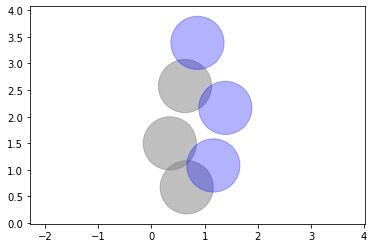

In [141]:
udmis.draw_graph();

In [142]:
tic = time.time()
E, occupations = udmis.brute_force()
toc = time.time()

print(E)
print(occupations)
print(f"computation took {toc-tic:2f} seconds")

3.0
[[False, False, True, False, True, True], [False, False, True, True, True, False], [True, False, True, False, True, False]]
computation took 0.000592 seconds


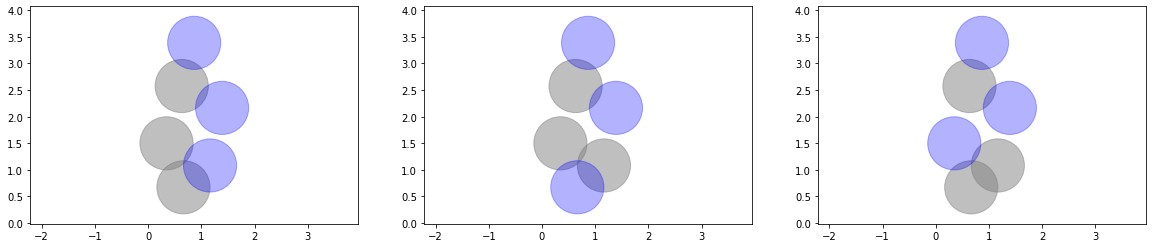

In [143]:
udmis.draw_graph(occupations = occupations);

# Bigger Random Graph

In [149]:
N = 20 #number of vertices
density = 1
scale = np.sqrt(N)/density
rand.seed(2021)
graph = [(rand.random()*scale,rand.random()*scale) for n in range(N)]

udmis = UDMIS(u, graph)

20


In [145]:
tic = time.time()
N = 5000
t = np.arange(N+1)
T_i = 100
T_f = 0.01

T = T_i * ((T_f/T_i) ** (t/N))

for t in range(N):
    # take a look at the abstract_udmis.py file to see how mc_step works
    temp = T[t]
    E = udmis.mc_step(T=temp)

toc = time.time()

print(-E)
# print(udmis.occupations)
print(f"computation took {toc-tic:2f} seconds")

10.0
computation took 4.436022 seconds


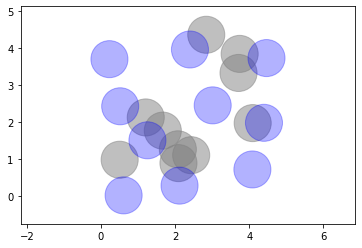

In [146]:
udmis.draw_graph();

In [147]:
tic = time.time()
E, occupations = udmis.brute_force()
toc = time.time()

print(E)
# print(occupations)
print(f"computation took {toc-tic:2f} seconds")

10.0
computation took 9.993146 seconds


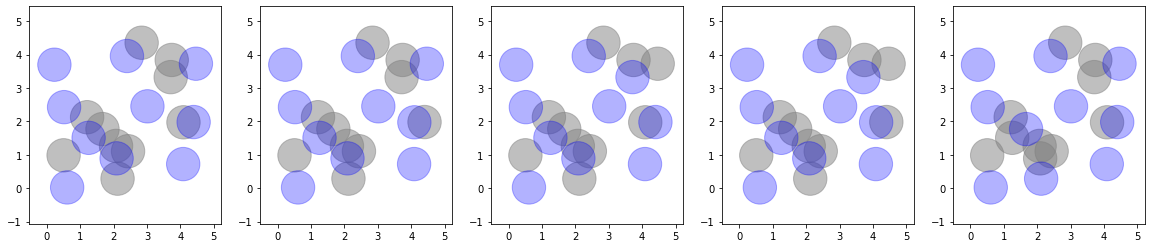

In [148]:
fig = udmis.draw_graph(occupations = occupations);